In [182]:
from wordcloud import WordCloud
import json, io, os, urllib2, string, nltk, re, math, sys
import subprocess, operator, community, wordcloud
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score
from collections import defaultdict, Counter
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import dok_matrix
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
cwd = os.getcwd() + '/'
data_dir = cwd + 'data/'

In [3]:
def get_page_links(listText):
    """
    Takes a string and finds all links within it. Returns a list of unique link names
    """
    link_pattern  = re.compile('\[\[(.*?)\]\]')
    links = re.findall(link_pattern, listText)
    data = list(set(links))
    return data

def get_page_content(outdir, out, page, baseUrl, action, d_format, cntnt = ""):
    """
    Pulls content out of a page
    
    :param outdir: Directory to write to
    :param out: File to write to
    :param page: Page to retrieve
    :param 
    """
    content = cntnt
    out = out.replace('/', '_') if '/' in out else out
    out = outdir + '/' + out

    fp = io.open(out, 'w', encoding = 'utf-8')
    query = '{0}{1}&titles={2}&{3}&{4}'.format(baseUrl,
                                               action,
                                               urllib2.quote(page.encode('utf-8')), 
                                               content, 
                                               d_format)
    
    resp  = json.loads(urllib2.urlopen(query).read())
    pageNo = resp['query']['pages'].keys()[0] # Gets page number
    
    if 'extract' in resp['query']['pages'][pageNo].keys(): 
        pageText = resp['query']['pages'][pageNo]['extract'].replace('\n', ' ')
        fp.write(pageText + '\n') # Writes the pagetext to file
        
    else: # We don't have text
        pageText = ""
    fp.close()
    
    return pageText

def get_pages(outList, pageList):
    """
    Gets pages, content and writes to files
    """
    # Get math names from list pages
    baseUrl       = 'https://en.wikipedia.org/w/api.php?'
    action        = 'action=query'
    content       = 'prop=revisions&rvprop=content'
    d_format      = 'format=json'
    
    outdir = os.getcwd() + '/data/'
    page_names = []
    
    for i in range(len(pageList)):
        p = pageList[i]
        b_out = outdir + '/' + outList[i] + '/raw/'

        fp = io.open(b_out + 'all.txt', 'a', encoding = 'utf-8') # Holds text for all phils in branch
        
        p_title = 'titles=%s' % p 
        query  = '{0}{1}&{2}&{3}&{4}'.format(baseUrl, action, p_title, content, d_format)
        
        resp = json.loads(urllib2.urlopen(query).read())
        try:
            pageNo = resp['query']['pages'].keys()[0] # Gets pageNumber
            listText = resp['query']['pages'][pageNo]['revisions'][0]['*'] # Gets text from json

            page_names.extend(get_page_links(listText)) # Gets link names
            cur_list = get_page_links(listText) # Gets page links

            for j in range(len(cur_list)): # For each name on the page get the page content, write the content
                cur_page = "_".join(cur_list[j].split())

                p_content = get_page_content(b_out, 
                                             cur_page, 
                                             cur_list[j], 
                                             baseUrl, 
                                             action, 
                                             d_format, 
                                             content = 'prop=extracts&exlimit=max&explaintext')

                fp.write(unicode(p_content + '\n'))
        except:
            continue

    fp.close()
    fp = io.open(outdir + 'names', 'w', encoding = 'utf-8')
    fp.write(unicode(",".join(page_names)))
        
    return page_names

wiki_link_pattern = '\[\[(.*?)\]\]'
out_dirs = ['actuaries', 'geometers', 'mathematical_probabilists', 'game_theorists', 'logicians', 'statisticians']
math_pages = ['List_of_actuaries', 'List_of_geometers','List_of_mathematical_probabilists', 
              'List_of_game_theorists', 'List_of_logicians', 'List_of_statisticians']

In [4]:
def download_from_title_wiki(title_list,outFolder):
    """
    --- Input
    
    title_list: list of title names to find in wikipedia
    outFolder : folder to write the page information
    
    --- Method
    
    Use wikipedia api to access the pages and download the information as json dictionaries and store them.
    
    Uses exceptions to catch cases where downloading the page did not work and to return a list of problem titles
    
    --- Return
    list of problem files
    
    """
    error_titles = []
    ### Use wikipedia API to get the pages
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action  = "action=query"
    #title   = "titles=?"
    content = "prop=revisions&rvprop=content"
    dataformat = "format=json"
    
    
    for t in title_list:
        pagename  = urllib2.quote(t.encode('utf-8'))
    
        title = 'titles=%s' % pagename
        query = "%s%s&%s&%s&%s" % (baseurl,action,title,content,dataformat)
    
        try: # try to load the json returned by the query
            thisjson = json.loads(urllib2.urlopen(query).read(),encoding='utf-8')
        
            try: # make sure that the download worked and we have downloaded the page
                
                pageNumber = thisjson['query']['pages'].keys()[0] # Unique ID
                
                text = thisjson['query']['pages'][pageNumber]['revisions'][0]['*'] # Get Text
            
                with io.open(outFolder+'/'+t+'.json', 'w', encoding='utf-8') as f:
                    f.write(unicode(json.dumps(thisjson, ensure_ascii=False)))
            
            except:
                # there was a download error for this page
                error_titles.append(t)
        except:
            # there was an error loading this page at all, problem with title in query
            error_titles.append(t)
    
    return list(set(error_titles))

In [5]:
def concat_maths(branch, branch_all):
    """Concatenate all text files (without links) for each branch and save them"""
    
    branch_dir = os.getcwd() + '/data/' + branch + '/raw/no_links/'
    data_dir = os.getcwd() + '/data/' + 'list_pages/'
    
    fp = io.open(branch_dir + 'all.txt', 'w', encoding = 'utf-8')
    
    for fh in os.listdir(branch_dir):
        f = io.open(branch_dir + fh, 'r', encoding = 'utf-8')
        fp.write(f.read() + '\n')

def write_outLinks_wiki(directory, file_name):
    
    fh = io.open(directory + file_name + '.json', 'r',encoding = 'utf-8').read()
    fo = io.open(directory + file_name + '_links.txt', 'w', encoding = 'utf-8')
    contents = json.loads(fh)
    
    wiki_link_pattern = r'\[\[(.*?)\]\]'
    
    pageNo = contents['query']['pages'].keys()[0]
    text = contents['query']['pages'][pageNo]['revisions'][0]['*']
            
    page_links = re.findall(wiki_link_pattern,text) # find every outlink in the page
    
    for link in page_links:
        fo.write(link + '\n')
    fo.close()
    
    return page_links

def find_outLinks_wiki(filepointer):
    
    fh = io.open(filepointer, 'r',encoding = 'utf-8').read()
    contents = json.loads(fh)
    
    wiki_link_pattern = r'\[\[(.*?)\]\]'
    
    pageNo = contents['query']['pages'].keys()[0]
    text = contents['query']['pages'][pageNo]['revisions'][0]['*']
            
    page_links = re.findall(wiki_link_pattern,text) # find every outlink in the page
    
    
    return page_links

def concat_names():
    """Write single file with all names in it"""
    
    data = os.getcwd() + '/data/list_pages/'
    fp = io.open(data + 'all_names.txt', 'w', encoding = 'utf-8')
    for fh in os.listdir(data):
        if fh.endswith('links.txt'):
            f = io.open(data + fh, 'r', encoding = 'utf-8')
            fp.write(f.read() + '\n')

In [6]:
files = ['List_of_actuaries', 'List_of_game_theorists', 'List_of_geometers', 
         'List_of_logicians', 'List_of_mathematical_probabilists', 'List_of_statisticians']

for fh in files:
    write_outLinks_wiki(data_dir + 'list_pages/', fh)

In [7]:
for folder in out_dirs:
    concat_maths(folder, folder + '_all.txt')

In [8]:
# Read in all names
names = io.open(data_dir + 'list_pages/all_names_cleaned.txt').read().encode('utf-8')
names = list(set(names.split('\n')))

# Create a directed graph with the mathematicians as nodes
math_graph = nx.DiGraph()
math_graph.add_nodes_from([name.decode('utf-8') for name in names])

########################## DO NOT RUN!!!!!!!!!!!! #############
get_pages(out_dirs, math_pages)
list_page_dir = os.getcwd() + '/data/list_pages'
err_pages = download_from_title_wiki(math_pages, list_page_dir) # Downloads list pages
concat_names()

#Download individual mathematician pages with links
all_pages = 'all_pages'
problemTitles = download_from_title_wiki(names, data_dir + all_pages)

In [9]:
# Add links to graph by going through each mathematicians page and finding links
for name in names:
    try:
        page = name.decode('unicode-escape') + '.json'
        links = find_outLinks_wiki(data_dir + 'all_pages/' + page)
        all_names = io.open(data_dir + 'list_pages/all_names_cleaned.txt', 'r', encoding = 'utf-8').read().encode('utf-8').split('\n')
        [math_graph.add_edge(name, x) for x in links if x in all_names]
    except:
        'No such file: %s' % page

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [10]:
nx.write_gpickle(math_graph, data_dir + '/pickles/math_graph.pickle')

# Get Basic Info on the Graph

In [11]:
print 'Number of Nodes: ', math_graph.number_of_nodes()
print 'Number of Links: ', math_graph.number_of_edges()

print 'Average Degree: {0:.2f}\n'.format(np.mean(math_graph.degree().values()))
print 'Median Degree: {0:.2f}\n'.format(np.median(math_graph.degree().values()))

## min and max
print 'Max Degree:   {0:.2f}\n'.format(np.max(math_graph.degree().values()))
print 'Min Degree:   {0:.2f}\n'.format(np.min(math_graph.degree().values()))

# mode (most common degree)
from scipy.stats import mode
modes = mode(math_graph.degree().values())
print '\nMode:\t%d (Number of Nodes with this value: %d)'% (modes[0][0],int(modes[1][0]))

Number of Nodes:  1154
Number of Links:  1452
Average Degree: 2.52

Median Degree: 1.00

Max Degree:   66.00

Min Degree:   0.00


Mode:	0 (Number of Nodes with this value: 496)


In [12]:
def topN_fromDicts(dictionary,N=10):
    # sort dictionary by value and return top N
    sorted_N = sorted(dictionary.items(), key=operator.itemgetter(1),reverse=True)[:N] 
    return sorted_N

def bottomN_fromDicts(dictionary,N=10):
    # sort dictionary by value and return top N
    sorted_N = sorted(dictionary.items(), key=operator.itemgetter(1),reverse=False)[:N] 
    return sorted_N

In [13]:
### In degree
math_in = math_graph.in_degree()
sorted_in_10 = topN_fromDicts(math_in,N=10)

math_in_Names = [x for x,y in sorted_in_10]
math_in_degs  = [y for x,y in sorted_in_10]

### Out degree
math_out = math_graph.out_degree()
sorted_out_10 = topN_fromDicts(math_out,N=10)

math_out_Names = [x for x,y in sorted_out_10]
math_out_degs  = [y for x,y in sorted_out_10]

top10 = pd.DataFrame(np.array([math_in_Names,
                               math_in_degs,
                               math_out_Names,
                               math_out_degs]).T,
                     index=range(1,11),
                     columns=['Top In','In Degree','Top Out', 'Out Degree'])
top10

,Top In,In Degree,Top Out,Out Degree
1,Aristotle,50,Bertrand Russell,23
2,Bertrand Russell,43,Charles Sanders Peirce,22
3,Karl Pearson,26,Ronald Fisher,20
4,Euclid,25,David Hilbert,16
5,Alfred Tarski,24,Georg Cantor,15
6,Charles Sanders Peirce,23,John Corcoran (logician),15
7,Ronald Fisher,22,John von Neumann,14
8,John von Neumann,22,Alfred Tarski,14
9,Gottlob Frege,20,Alan Turing,13
10,Alonzo Church,18,Gottlob Frege,12


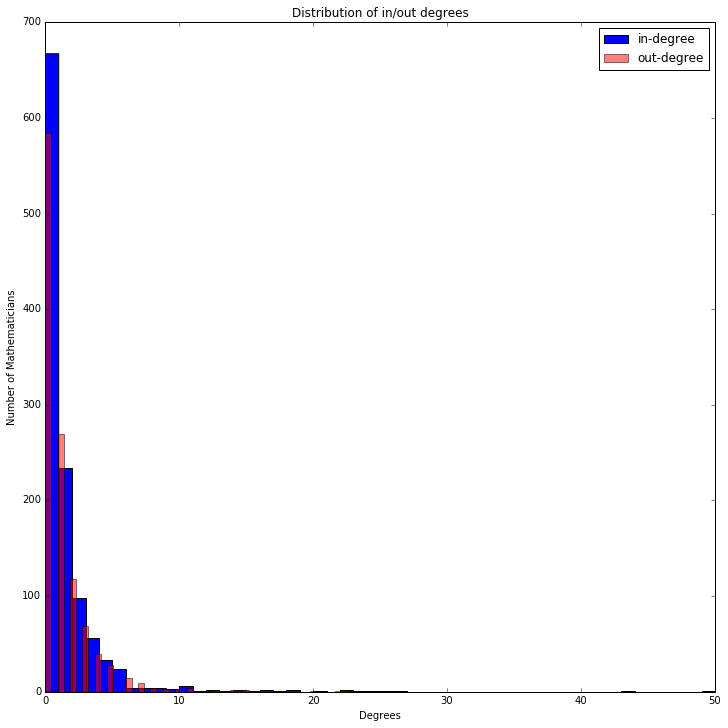

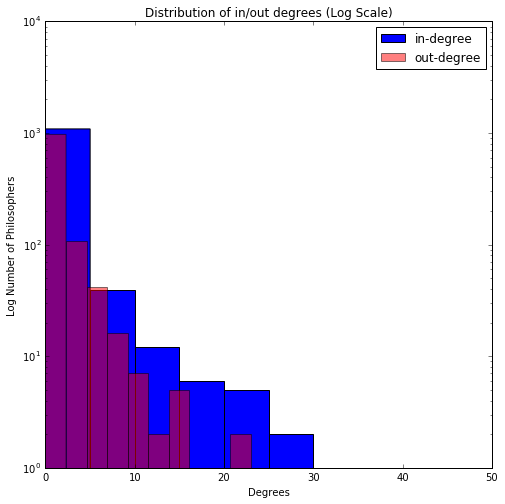

In [14]:
plt.figure(figsize=(12,12))
plt.hist(math_in.values(),bins=50,color='blue',label='in-degree')
plt.hist(math_out.values(),bins=50,color='red',alpha=0.5,label='out-degree')
plt.legend()
plt.title('Distribution of in/out degrees')
plt.xlabel('Degrees')
plt.ylabel('Number of Mathematicians')
plt.savefig(data_dir + "images/in_out_log_linear.png", bb_inches='tight')
plt.show()

plt.figure(figsize=(8,8))
plt.hist(math_in.values(),color='blue',label='in-degree',log=True)
plt.hist(math_out.values(),color='red',alpha=0.5,label='out-degree',log=True)
plt.legend()
plt.title('Distribution of in/out degrees (Log Scale)')
plt.xlabel('Degrees')#?
plt.ylabel('Log Number of Philosophers')#?
plt.savefig(data_dir + "images/in_out_log_log.png", bb_inches='tight')
plt.show()

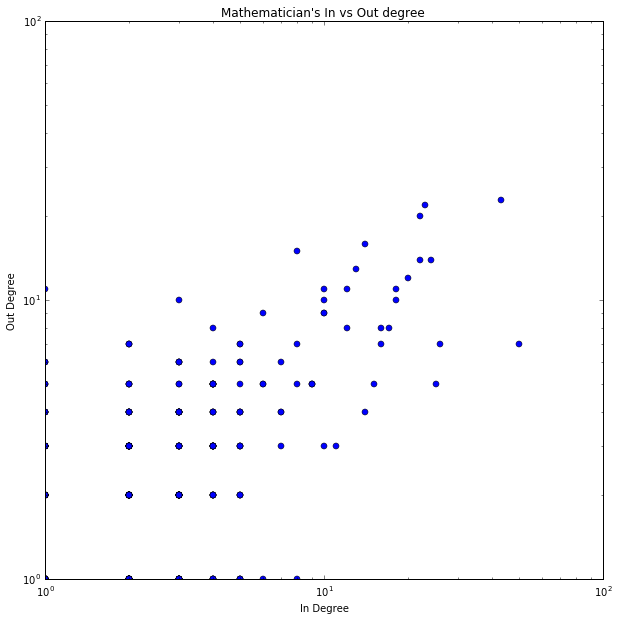

In [15]:
fix, ax = plt.subplots(figsize=(10,10))
for m in math_graph.nodes():
    inn  = math_in[m]
    outt = math_out[m]
    ax.plot(inn,outt,'bo')
ax.set_yscale('log')
ax.set_xscale('log')
plt.title('Mathematician\'s In vs Out degree ')
plt.xlabel('In Degree')
plt.ylabel('Out Degree')
plt.savefig(data_dir + 'images/In v out degree.png', bb_inches='tight')
plt.show()

In [16]:
# Centrality
## undirected graph
math_graph_undirected = math_graph.to_undirected()

## The GCC
giant = max(nx.connected_component_subgraphs(math_graph_undirected), key=len)

## 
weak = max(nx.weakly_connected_component_subgraphs(math_graph),key=len)

In [17]:
bCentral = nx.betweenness_centrality(weak)
top5_betweenCentrality = topN_fromDicts(bCentral,N=5)
for tb in top5_betweenCentrality:
    print tb

(u'Bertrand Russell', 0.11804835481107404)
(u'Ronald Fisher', 0.10547526865756197)
(u'Milton Friedman', 0.0651579316560905)
(u'John von Neumann', 0.06029515476620272)
(u'John Maynard Keynes', 0.052742137383594734)


In [18]:
"""
Note: For directed graphs this is “left” eigevector centrality which corresponds to the in-edges in the graph. 
For out-edges eigenvector centrality first reverse the graph with G.reverse().
"""

in_eig_central = nx.eigenvector_centrality(weak)
sorted_in_eig_5 = topN_fromDicts(in_eig_central,N=5)
print 'Top 5 eigen centrality IN edges'
for x in sorted_in_eig_5:
     print x
print ''

out_eig_central = nx.eigenvector_centrality(weak.reverse())
sorted_out_eig_5 = topN_fromDicts(out_eig_central,N=5)
print '\nTop 5 eigen centrality OUT edges'
for y in sorted_out_eig_5:
    print y

Top 5 eigen centrality IN edges
(u'Bertrand Russell', 0.4164868307116189)
(u'Gottlob Frege', 0.24905868740465903)
(u'Alfred Tarski', 0.24345915341198865)
(u'Ludwig Wittgenstein', 0.2431995071317573)
(u'John von Neumann', 0.20821566137778677)


Top 5 eigen centrality OUT edges
(u'Bertrand Russell', 0.32079269724107234)
('Charles Sanders Peirce', 0.29923786993899865)
('Georg Cantor', 0.2165598331026345)
('Jaakko Hintikka', 0.2097900546429442)
(u'Gottlob Frege', 0.19023617292174907)


In [19]:
### Make a table with the top 5 using different centrality measure

sorted_in_5 = topN_fromDicts(math_in,N=5)
math_in_Names = [x for x,y in sorted_in_5]

sorted_out_5 = topN_fromDicts(math_out,N=5)
math_out_Names = [x for x,y in sorted_out_5]

eig_in_Names = [x for x,y in sorted_in_eig_5]
eig_out_Names = [x for x,y in sorted_out_eig_5]

betweenness_Names= [x for x,y in top5_betweenCentrality]

tops5s = np.array([math_in_Names,math_out_Names,eig_in_Names,eig_out_Names,betweenness_Names]).T

cols=['In Degree Centrality','Out Degree Centrality','In Eigenvector Centrality', 'Out Eigenvector Centrality','Betweenness Centrality']
top5 = pd.DataFrame(tops5s,index=range(1,6),columns=cols)
top5

,In Degree Centrality,Out Degree Centrality,In Eigenvector Centrality,Out Eigenvector Centrality,Betweenness Centrality
1,Aristotle,Bertrand Russell,Bertrand Russell,Bertrand Russell,Bertrand Russell
2,Bertrand Russell,Charles Sanders Peirce,Gottlob Frege,Charles Sanders Peirce,Ronald Fisher
3,Karl Pearson,Ronald Fisher,Alfred Tarski,Georg Cantor,Milton Friedman
4,Euclid,David Hilbert,Ludwig Wittgenstein,Jaakko Hintikka,John von Neumann
5,Alfred Tarski,Georg Cantor,John von Neumann,Gottlob Frege,John Maynard Keynes


In [20]:
a = nx.degree_centrality(giant)

top20_nodes    = [x for x,y in topN_fromDicts(nx.degree_centrality(giant),N=80)][:20]
lesser20_nodes = [x for x,y in topN_fromDicts(nx.degree_centrality(giant),N=80)][-20:]

Whole_Graph = nx.degree_assortativity_coefficient(giant)
TopNodesGraph = nx.degree_assortativity_coefficient(giant,nodes=top20_nodes)
LesserNodes    = nx.degree_assortativity_coefficient(giant,nodes=lesser20_nodes)

print 'degree_assortativity_coefficient for varying nodes'
print 'Whole Graph:\t\t ', Whole_Graph
print 'Top Connected Nodes:\t ',TopNodesGraph
print 'Lesser Connected Nodes:\t ',LesserNodes

degree_assortativity_coefficient for varying nodes
Whole Graph:		  -0.00168335676968
Top Connected Nodes:	  -0.107275408608
Lesser Connected Nodes:	  -0.6


In [21]:
#### Branches and communities
list_dir = data_dir + 'list_pages/'
mathematician_files = ['actuaries_cleaned.txt', 'geometers_cleaned.txt', 
                       'game_theorists_cleaned.txt', 'logicians_cleaned.txt',
                       'mathematical_probabilists_cleaned.txt', 'statisticians_cleaned.txt']

branches = [x.split('.')[0] for x in mathematician_files] # just for nice naming
branch_dict = defaultdict(lambda:set()) # default dictionary with default as sets

wiki_link_pattern = r'\[\[(.*?)\]\]'

### Create a lists of sets of names of philosophers in each branch

math_lists = []
for math_file in mathematician_files:
    f     = io.open(list_dir + math_file, 'r')
    maths = f.read().split('\n')
    math_lists.append(set(maths))

In [22]:
in_other_branches = []
for i in range(len(math_lists)): # 
    
    # make a copy of the list of sets of philosophers
    alls = [x for x in math_lists] 
    
    # remove this set from the list of sets
    this_math_set = alls.pop(i)
    
    # Using set differences we can find philosophers who belong
    # only to this branch
    alone = this_math_set - set.union(*alls)
    
    # put this in a dictionary. 
    #key = branch; value = set of phils belonging to only this branch
    branch_dict[branches[i]]= alone           
    
    ## keep a list of philosophers who are in other branches as well as this
    maths_in_others = list(this_math_set - alone)
    in_other_branches.extend(maths_in_others)
    
in_other_branches = list(set(in_other_branches))

In [23]:
for i in in_other_branches:
    max_edges = -np.inf    # for checking max connections for this philosopher over each branch
    for k in branch_dict.keys():
#        print [x.decode('utf-8').encode('utf-8') for x in branch_dict[k]]
        
        # add the number of links between i and everyone in this branch
        num_edges = sum([math_graph_undirected.number_of_edges(i,x.encode('utf-8')) for x in branch_dict[k]]) 

        # is this the branch where the philosopher is most connected?
        if num_edges > max_edges:
            max_edges = num_edges
            best_branch = k
            
    ## now assign this philosopher to the branch where they connect most in
    #print 'Philosopher: %s \nBranch: %s\n' % (i,best_branch)
    branch_dict[best_branch].add(i)

In [24]:
def PerCommunityPartitionModularity(G,C):
    """
    Input: 
    - G: a graph
    - C: a subgraph of G
    
    """
    
    L   = float(G.number_of_edges()) # number of links in entire graph
    L_c = float(C.number_of_edges()) # number of links in subgraph
    k_c = float(sum(nx.degree(C).values())) # total node degree in subgraph
    
    lhs = L_c / L
    rhs = (k_c /(2*L)) ** 2
    
    M_c = lhs - rhs
    
    return M_c

def partitionModularity(G,partitionDictionary):
    
    """
    Input:
    
        - G: (undirected?) Graph
        - partitionDictionary: a dictionry 
    of sets belonging to different communities within G
    
    
    """
    ## list comprehension for computing the PartitionModularity accross graph
    
    M = sum([PerCommunityPartitionModularity(G,G.subgraph(list(nodes))) 
             for nodes in [partitionDictionary[k] 
                           for k in partitionDictionary.keys()]])
    
    return M

In [25]:
giant          = max(nx.connected_component_subgraphs(math_graph_undirected), key=len)
best_partition = community.best_partition(giant)
M_Louvain_alg  = community.modularity(best_partition, giant)

print 'Modularity using Louvain-algorithm over GCC', M_Louvain_alg

M = partitionModularity(math_graph_undirected, branch_dict)
print 'Modularity Over entire graph: ', M

M_giant = partitionModularity(giant, branch_dict)
print 'Modularity Over GCC: ', M_giant

Modularity using Louvain-algorithm over GCC 0.650868725323
Modularity Over entire graph:  0.556060238001
Modularity Over GCC:  0.551442601486


In [26]:
B = 6; # 6 branches
C = len(set(best_partition.values())) # number of communities
D = pd.DataFrame(index=branches, columns=range(C))

## Given a dictionary with philosophers as keys and partitions as values, 
#  create a new dictionaries with communitiy id as keys
#  sets of philosophers in that comunitiy as values

partition_dict = defaultdict(lambda:set())
for i in range(C):
    partition_dict[i] = set([x for x,y in best_partition.items() if y == i])

    
## Now we have dictionaries where values are sets and we can find the intersection of branch and community members
for b in branches:
    for j in range(C):
        D.ix[b,j] = len((branch_dict[b] & partition_dict[j]))
        
# Display the confusion Matrix        
D

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
actuaries_cleaned,0,1,0,0,0,0,1,0,0,3,0,3,0,0,0,0,0
geometers_cleaned,25,1,19,20,2,1,5,7,0,5,0,0,1,0,0,0,0
game_theorists_cleaned,0,3,0,1,1,0,0,0,0,0,0,2,0,6,1,0,0
logicians_cleaned,40,4,2,17,2,55,49,0,0,2,4,1,8,0,0,0,0
mathematical_probabilists_cleaned,0,1,9,1,14,2,2,2,1,0,0,2,0,1,1,0,0
statisticians_cleaned,0,86,2,3,7,1,9,8,14,9,0,31,0,0,33,24,8


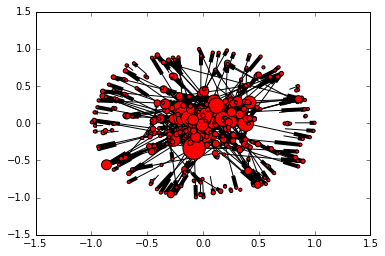

In [27]:
nx.draw_networkx(math_graph, 
        nodelist=math_graph.degree().keys(), 
        node_size=[v * 10 for v in math_graph.in_degree().values()], 
        with_labels = False)

plt.show()

In [28]:
def get_names():
    """Just gets all names of phils"""
    with io.open(data_dir + '/list_pages/all_names_cleaned.txt', 'r', encoding = 'utf-8') as fp:
        lines = fp.readlines()
        return lines[0].split(',')

def clean_sentences(words):
    """Cleans sentences"""
    stem = nltk.stem.porter.PorterStemmer()
    lem = nltk.WordNetLemmatizer()
    
    names = get_names()
    stop = nltk.corpus.stopwords.words('english')
    
    punct = string.punctuation # punctuation characters
    num = re.compile('\d+(\.\d+)?')
    words = nltk.word_tokenize(" ".join(words).lower())
    
    cleaned = []
    for w in words:
        if w not in " ".join(names).split() and w not in stop and w not in punct and w.isalpha():
            try:
                if not num.match(str(w)):
                    cleaned.append(lem.lemmatize(stem.stem(w)))
            except:
                continue
    return cleaned

In [143]:
def alt_get_tf(counts, branch, cleaned):
    """Calculate TF and returns modified dictionary"""
    print "working on", branch
    
    count_obj = Counter(cleaned)
    for word, count in count_obj.items():
        counts[branch][word]['tf'] = count / float(len(cleaned))
        counts[branch][word]['idf'] = []
        
    return counts

def get_idf(counts):
    """Gets DF as a list of unique branches. Returns modified dictionary"""
    counts2 = defaultdict(list)
    for branch in counts:
        for word in counts[branch]:
            counts2[word].append(branch)
            counts2[word] = list(set(counts2[word]))
            
                
    print "Inverse Document Frequencies: Done"
    return counts2

def calc_tfidf(counts, df):
    """ Calculates the TF-IDF and fills it in the dictionary. Returns modified dictionary"""
    words = []
    docs = 6

    for branch in counts:
        for word in counts[branch]:
            idf = float(len(df[word]))
            counts[branch][word]['tfidf'] = counts[branch][word]['tf'] * math.log((6 / idf), 2) + 1
        
    print "TF-IDF: Done"
    return counts

def create_tuples(counts):
    """Create tuples of branch, word, and TF-IDF."""
    tupList = []
    for branch in counts:
        for word in counts[branch]:
            tupList.append((branch, word, counts[branch][word]['tfidf']))
    return tupList

In [144]:
folders = ['actuaries', 'game_theorists', 'mathematical_probabilists', 'logicians', 'statisticians', 'geometers']

actuaries_all = io.open(data_dir + 'actuaries/raw/no_links/all.txt').readlines()
game_theorists_all = io.open(data_dir + 'game_theorists/raw/no_links/all.txt').readlines()
mathematical_probabilists_all = io.open(data_dir + 'mathematical_probabilists/raw/no_links/all.txt').readlines()
logicians_all = io.open(data_dir + 'logicians/raw/no_links/all.txt').readlines()
geometers_all = io.open(data_dir + 'geometers/raw/no_links/all.txt').readlines()
statisticians_all = io.open(data_dir + 'statisticians/raw/no_links/all.txt').readlines()

In [145]:
actuaries_cleaned = clean_sentences(actuaries_all)
game_theorists_cleaned = clean_sentences(game_theorists_all)
mathematical_probabilists_cleaned = clean_sentences(mathematical_probabilists_all)
logicians_cleaned = clean_sentences(logicians_all)
geometers_cleaned = clean_sentences(geometers_all)
statisticians_cleaned = clean_sentences(statisticians_all)

In [166]:
counts = []
counts.append(actuaries_cleaned)
counts.append(game_theorists_cleaned)
counts.append(mathematical_probabilists_cleaned)
counts.append(logicians_cleaned)
counts.append(geometers_cleaned)
counts.append(statisticians_cleaned)

In [147]:
for count in counts:
    print Counter(count).most_common(5) # Prints the 5 most common terms for each list

[(u'actuari', 256), (u'work', 215), (u'mathemat', 182), (u'life', 168), (u'univers', 166)]
[(u'neumann', 248), (u'von', 238), (u'theori', 213), (u'univers', 192), (u'game', 186)]
[(u'pascal', 111), (u'mathemat', 63), (u'work', 62), (u'de', 61), (u'univers', 57)]
[(u'logic', 2440), (u'univers', 1873), (u'work', 1584), (u'mathemat', 1476), (u'philosophi', 1424)]
[(u'mathemat', 1053), (u'work', 1034), (u'univers', 849), (u'theori', 652), (u'geometri', 569)]
[(u'statist', 1779), (u'univers', 1212), (u'work', 899), (u'mathemat', 773), (u'econom', 619)]


In [148]:
countDict = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

In [149]:
countDict = alt_get_tf(countDict, 'actuaries', actuaries_cleaned)
countDict = alt_get_tf(countDict, 'game_theorists', game_theorists_cleaned)
countDict = alt_get_tf(countDict, 'mathematical_probabilists', mathematical_probabilists_cleaned)
countDict = alt_get_tf(countDict, 'logicians', logicians_cleaned)
countDict = alt_get_tf(countDict, 'geometers', geometers_cleaned)
countDict = alt_get_tf(countDict, 'statisticians', statisticians_cleaned)

working on actuaries
working on game_theorists
working on mathematical_probabilists
working on logicians
working on geometers
working on statisticians


In [150]:
dfDict = get_idf(countDict)
countDict = calc_tfidf(countDict, dfDict)
tupList   = create_tuples(countDict)
tupSorted = sorted(tupList, key=lambda tup: tup[2])[::-1]

Inverse Document Frequencies: Done
TF-IDF: Done


In [153]:
data = {'logicians': [], 'statisticians': [], 'geometers': [], 'mathematical_probabilists': [], 'game_theorists': [], 'actuaries': []}
banned = ['actuari', ]
for i, tup in enumerate(tupSorted):
    if i < 10:
        continue
    if len(data[tup[0]]) < 10:
        data[tup[0]].append(tup[1])

df = pd.DataFrame(data, columns = ['logicians', 'statisticians', 'geometers', 'mathematical_probabilists', 'game_theorists', 'actuaries'])
df

,logicians,statisticians,geometers,mathematical_probabilists,game_theorists,actuaries
0,taymiyyah,ej,atiyah,poisson,von,witt
1,alcuin,hilb,leonardo,jacquelin,aumann,halley
2,ibn,galton,pythagora,shuffl,arrow,milliman
3,ture,kuznet,kepler,kesten,axelrod,finlaison
4,wittgenstein,friedman,archimed,percol,rapoport,petti
5,quin,chuprov,penros,riffl,roth,actuari
6,boethiu,walker,chern,tube,kenneth,macaulay
7,tarski,econometr,ibn,besicovitch,pearc,elderton
8,whitehead,luntz,fuller,shiryaev,selten,annuiti
9,modal,basebal,yau,onicescu,altruism,savitz


In [154]:
branch_text = []
for branch in folders:
    print branch
    text = ""
    for tup in tupSorted:
        if tup[0] == branch:
            tups = tup[1] + ' '
            text += tups * int(tup[2]) # Each word is multiplied by its rounded down frequency
    branch_text.append((branch, text))

actuaries
game_theorists
mathematical_probabilists
logicians
statisticians
geometers


Actuaries


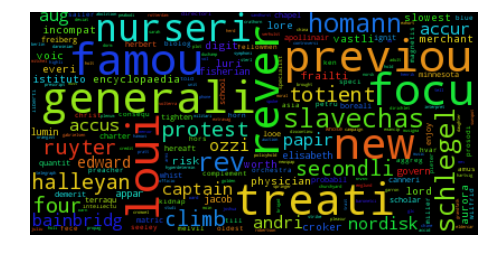

Game Theorists


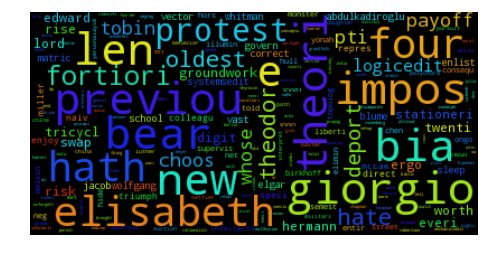

Probabilists


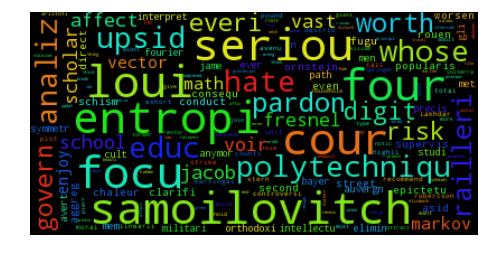

Logicians


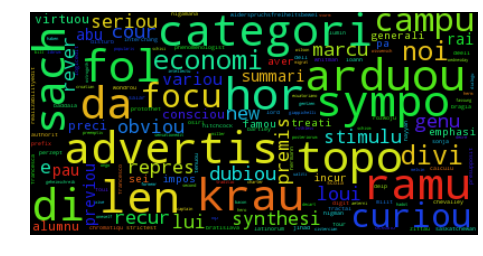

Statisticians


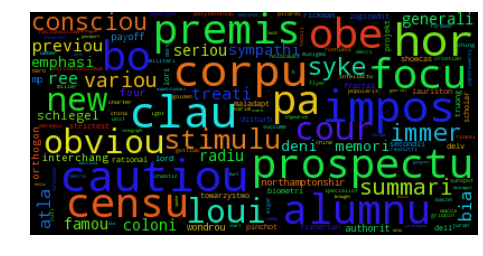

Geometers


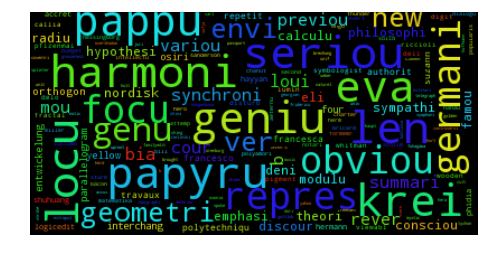

In [155]:
print "Actuaries"
wordcloud = WordCloud(max_font_size=40).generate(branch_text[0][1])
plt.figure(figsize=(8,4), dpi=400)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig(data_dir + 'images/actuaries.png', bb_inchies='tight')
plt.show()

print "Game Theorists"
text = branch_text[1][1]
wordcloud = WordCloud(max_font_size=40).generate(branch_text[1][1])
plt.figure(figsize=(8,4), dpi=400)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig(data_dir + 'images/game_theorists.png', bb_inchies='tight')
plt.show()

print "Probabilists"
wordcloud = WordCloud(max_font_size=40).generate(branch_text[2][1])
plt.figure(figsize=(8,4), dpi=400)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig(data_dir + 'images/probabilists.png', bb_inchies='tight')
plt.show()

print "Logicians"
wordcloud = WordCloud(max_font_size=40).generate(branch_text[3][1])
plt.figure(figsize=(8,4), dpi=400)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig(data_dir + 'images/logicians.png', bb_inchies='tight')
plt.show()

print "Statisticians"
wordcloud = WordCloud(max_font_size=40).generate(branch_text[4][1])
plt.figure(figsize=(8,4), dpi=400)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig(data_dir + 'images/statisticians.png', bb_inchies='tight')
plt.show()

print "Geometers"
wordcloud = WordCloud(max_font_size=40).generate(branch_text[5][1])
plt.figure(figsize=(8,4), dpi=400)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig(data_dir + 'images/geometers.png', bb_inchies='tight')
plt.show()

In [156]:
def createMathDict():
    folders = ['actuaries', 'game_theorists', 'mathematical_probabilists', 'logicians', 'statisticians', 'geometers']
    articleId = 0
    
    # Create the mathematician dict {math: 'words': { [], 'ID': int}, 'word': int}
    uniqMathDict = defaultdict(lambda: defaultdict(int))
    articleID = 0
    
    for path in folders:
        folder_dir = data_dir + path + '/raw/no_links/'
        files = os.listdir(folder_dir)
        for fh in files:
            if fh != 'all.txt' and not fh.endswith('_all.txt'):
                fp = io.open(folder_dir + fh, 'r', encoding = 'utf-8')
                cleaned = clean_sentences(fp.readlines())
                uniqMathDict[fh]['words'] = cleaned
                uniqMathDict[fh]['ID'] = articleID
                articleID += 1
                
                cnt = Counter(cleaned)
                for word, freq in cnt.items():
                    uniqMathDict[fh][word] = freq
    return uniqMathDict

In [157]:
mathDict = createMathDict()

In [158]:
def create_idfDict(countsDict):
    # Creates a dict for getting DF for each word
    idfDict = defaultdict(list)
    for article in countsDict:
        for word in countsDict[article]['words']:
            if article not in idfDict[word]:
                idfDict[word].append(article)
    return idfDict

def cutOffWords(countsDict):
    # Let's just remove some words
    idfDict = create_idfDict(countsDict)
    for word in idfDict:
        if len(idfDict[word]) < 3:
            idfDict[word] = []

    return idfDict

In [159]:
idfDict = cutOffWords(mathDict)
vals = []
for article in mathDict.keys():
    vals.append((mathDict[article]['ID'], len(mathDict[article]['words']))) # List of (article, token) number tuples

vals = sorted(vals, key=lambda tup: tup[1])[::-1]
xvals = [i for i in range(len(vals))]
yvals = [vals[i][1] for i in range(len(vals))]

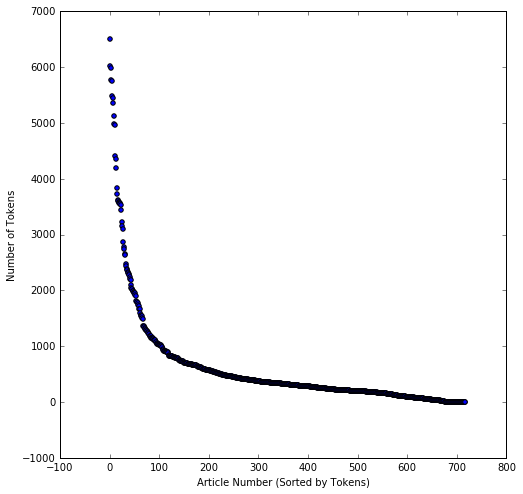

In [160]:
plt.figure(figsize=(8,8), dpi=800)
plt.scatter(xvals, yvals)
plt.ylabel('Number of Tokens')
plt.xlabel('Article Number (Sorted by Tokens)')
plt.savefig(data_dir + 'images/tokenCountPlot.png', bb_inches='tight')
plt.show()

In [161]:
len(idfDict.keys()) # Corresponds to number of unique words since each word is a key

27846

In [162]:
mapDict = defaultdict(list) # {'articles': [], 'words': []}
mapDict['articles'] = [article for article in mathDict]
mapDict['words'] = [word for word in idfDict]

math2ind = {math:j for math,j in zip(mapDict['articles'],range(len(mapDict['articles'])))}
ind2math = {j:math for math,j in zip(mapDict['articles'],range(len(mapDict['articles'])))}
ind2word = {i: word for word, i in zip(mapDict['words'], range(len(mapDict['words'])))}
word2ind = {word:i  for word, i in zip(mapDict['words'], range(len(mapDict['words'])))}

In [163]:
math2branch = defaultdict(list)
for branch in folders:
    path = os.listdir(os.getcwd() + '/data/' + branch + '/raw/no_links/')
    for it in path:
        if it != 'all.txt':
            math2branch[it.decode('utf-8')] = branch
            

In [167]:
d_matrix = dok_matrix((len(mapDict['words']),len(mapDict['articles'])))
n_docs = d_matrix.shape[1]
indDict = defaultdict(list)

for i, word in enumerate(mapDict['words']): # For every word and index
    if i % 1000 == 0:
        print i
    for j, article in enumerate(mathDict): # For every article and index
        if word in mathDict[article]['words']: # If the word is in the article
            df = len(idfDict[word]) # Get the Document Frequency
            
            if df == 0: # If it's been cut off
                d_matrix[i, j] = 0.000001
                
            else: # Otherwise save the tf-idf
                tf  = mathDict[article][word]
                d_matrix[i, j] = math.log(1 + mathDict[article][word], 2) * math.log((n_docs / df))
    
    norm = 1.0 / np.sqrt(sum(el**2 for el in d_matrix.getrow(i).toarray()))
    d_matrix[i,:] *= norm 

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


In [168]:
vals = []
yvals = sorted(d_matrix.values(), reverse = True)
xvals = [range(len(yvals))]

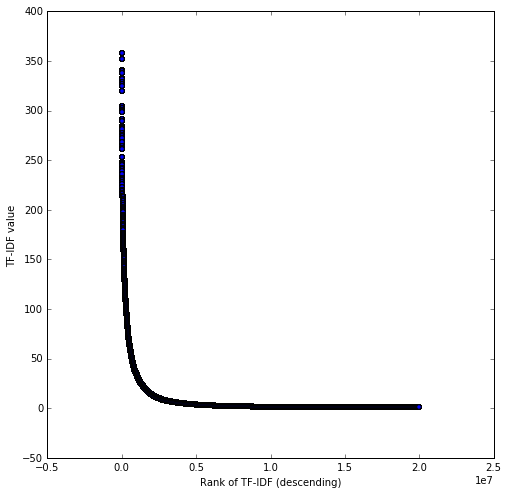

In [195]:
plt.figure(figsize=(8,8), dpi=800)
plt.scatter(xvals, yvals)
plt.ylabel('TF-IDF value')
plt.xlabel('Rank of TF-IDF (descending)')
plt.savefig(data_dir + 'images/tfidfRankPlot.png', bb_inches='tight')
plt.show()

In [180]:
def make_X_y(count_matrix, int2phil, phil2branch):
    
    X = count_matrix.copy().T # was words,phils want phils,words
    y = []
    
    for i in range(X.shape[0]):
        yes = False
        # i is the phil index
        phil_name = int2phil[i].replace('_', ' ')
        this_branch = phil2branch[phil_name]
        y.append(this_branch)
        
    return X, np.array(y)

def make_X_y(count_matrix, int2phil, phil2branch):
    
    X = count_matrix.copy().T # was words,phils want phils,words
    y = []
    
    for i in range(X.shape[0]):
        yes = False
        # i is the phil index
        math_name = ind2math[i]
        this_branch = math2branch[math_name]
        y.append(this_branch)
        
    return X, np.array(y)
    
def classify_me(X,y, classifier):
    # Label encoding
    le = LabelEncoder()
    ys = le.fit_transform(y)
    
    # Use NB multinomial
    clf = classifier
    
    # Use train_test_split to get 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(X, ys.T, test_size=0.20)
    
    # fit the classifier
    clf.fit(X_train,y_train)
    
    # predict on unseen test data
    pred = clf.predict(X_test)
    
    # Get the fraction correct: i.e. accuracy score
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    
    return acc, prec

In [171]:
## Make a matrix of occurences
count_matrix = dok_matrix((len(mapDict['words']),len(mapDict['articles'])))
n_docs = count_matrix.shape[1]
indDict = defaultdict(list)

for i, word in enumerate(mapDict['words']):    # For every word and index
    for j, article in enumerate(mathDict):     # For every article and index
        if word in mathDict[article]['words']: # If the word is in the article
            tf  = mathDict[article][word]
            if tf == 0:                        # If it's not in this doc
                count_matrix[i, j] = 0
            else:
                count_matrix[i, j] = tf

In [203]:
svm = SVC()
LR = LogisticRegression()
NB = MultinomialNB()

X,y = make_X_y(count_matrix.tocsr(),ind2math,math2branch)

prec_nb = []
acc_nb = []
prec_lr = []
acc_lr = []
prec_svm = []
acc_svm = []
accs = []
precs = []
for i in range(20):
    res_svm = classify_me(X, y, svm)
    prec_svm.append(res_svm[1])
    acc_svm.append(res_svm[0])
    precs.extend(prec_svm)
    accs.extend(acc_svm)
    
    res_nb  = classify_me(X, y, NB)
    prec_nb.append(res_nb[1])
    acc_nb.append(res_nb[0])
    precs.extend(prec_nb)
    accs.extend(acc_nb)
    
    res_lr  = classify_me(X, y, LR)
    prec_lr.append(res_lr[1])
    acc_lr.append(res_lr[0])
    precs.extend(prec_lr)
    accs.extend(acc_lr)
    

print 'NB BoW accuracy: ',(classify_me(X,y, NB))
print 'LR BoW accuracy: ',(classify_me(X,y, LR))
print 'SVM BoW accuracy: ',(classify_me(X,y, svm))

NB BoW accuracy:  (0.64583333333333337, 0.53956461056644878)
LR BoW accuracy:  (0.74305555555555558, 0.72284236046179418)
SVM BoW accuracy:  (0.49305555555555558, 0.51304494598765438)


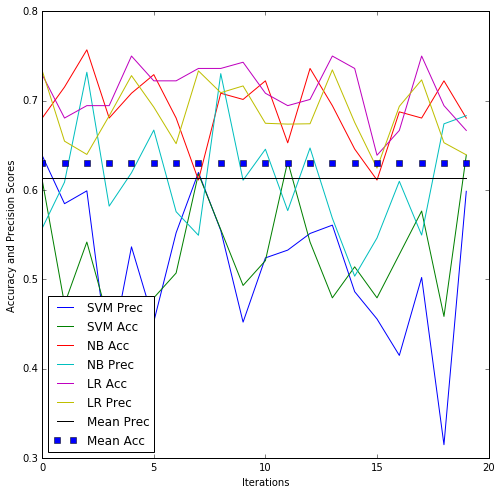

In [242]:
acc_mean = []
prec_mean = []
for i in range(20):
    acc_mean.append(np.mean(accs))
    prec_mean.append(np.mean(precs))
plt.figure(figsize=(8,8), dpi=800)
plt.plot(range(20), prec_svm, 'b', label = 'SVM Prec')
plt.plot(range(20), acc_svm, 'g', label = 'SVM Acc')
plt.plot(range(20), acc_nb, 'r', label = 'NB Acc')
plt.plot(range(20), prec_nb, 'c', label = 'NB Prec')
plt.plot(range(20), acc_lr, 'm', label = 'LR Acc')
plt.plot(range(20), prec_lr, 'y', label = 'LR Prec')
plt.plot(range(20), prec_mean, 'k', label = 'Mean Prec')
plt.plot(range(20), acc_mean, 's', label = 'Mean Acc')
plt.xlabel('Iterations')
plt.ylabel('Accuracy and Precision Scores')
plt.legend(loc='lower left')
plt.savefig(data_dir + 'images/scorePlot.png', bb_inches='tight')
plt.show()

In [250]:
# Naive Bayes
print min(acc_nb)
print max(acc_nb)
print min(prec_nb)
print max(prec_nb)

# SVM
print(min(acc_svm))
print(max(acc_svm))
print(min(prec_svm))
print(max(prec_svm))

# LR
print(min(acc_lr))
print(max(acc_lr))
print(min(prec_lr))
print(max(prec_lr))

0.611111111111
0.756944444444
0.503449328449
0.731828703704
0.4375
0.638888888889
0.314689867424
0.638551411989
0.638888888889
0.75
0.624437088015
0.734513634514
